# Customer Segmentation

Customer Segmentation is the practice of dividing the customers of a company into different groups that possess similarities in each group. The objective of segmenting the customers is to ascertain how to relate to customers in each segment so that we can maximize the value of each customer to the business.
Ideally this allows us to tailor our appraoch to each customer group based on their interests, demographic profile or even preferered method of communication and interaction.

## Background
In this notebook we seek to identify customer segments so that we can deliver insights about our data through clusterig
and means. This will be used to drive business decisions in tailoring approaches to the different customer bases/types.
The data was obtained from [Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python) and it includes features such as Customer ID, Age, Gender, Annual Income and Spending Score (which was assigned based on the internal metrics of the company.

- 1 Importing libraries and data
- 2 Exploratory Data Analysis
- 3 Data PreProcessing
- 4 Build and Evaluate Models - K-Means, Hierarchical Clustering, Principal Component Analysis
- 5 Conclusions

## Importing Libraries and data

In [1]:
# Import libraries for dataframes and visualizations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import sea
from kneed import KneeLocator

# Import libraries for clustering
import sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy import stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# to address possible warnings
# import warnings
# warnings.filterwarnings(action='once')

# reading in our data
df = pd.read_csv('Mall_Customers.csv')

# set seed for reproducibility
np.random.seed(42)

## Exploratory Data Analysis

In [2]:
# looking at the head of data
df.head(10)

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72

In [3]:
# Check for missing values
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

The data is not missing any values

In [4]:
# renaming colums for ease
df.rename(index=str, columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Score'}, inplace=True)
df.head()

CustomerID  Gender  Age  Income  Score
0           1    Male   19      15     39
1           2    Male   21      15     81
2           3  Female   20      16      6
3           4  Female   23      16     77
4           5  Female   31      17     40

In [5]:
# Looking at the dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  200 non-null    int64 
 1   Gender      200 non-null    object
 2   Age         200 non-null    int64 
 3   Income      200 non-null    int64 
 4   Score       200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.4+ KB


In [6]:
# Looking at some quick stats of the data
df.describe()

CustomerID         Age      Income       Score
count  200.000000  200.000000  200.000000  200.000000
mean   100.500000   38.850000   60.560000   50.200000
std     57.879185   13.969007   26.264721   25.823522
min      1.000000   18.000000   15.000000    1.000000
25%     50.750000   28.750000   41.500000   34.750000
50%    100.500000   36.000000   61.500000   50.000000
75%    150.250000   49.000000   78.000000   73.000000
max    200.000000   70.000000  137.000000   99.000000

We can see from the data that the mean age is 38.85, the mean income is 60.56k and the mean spending score is 50.2.

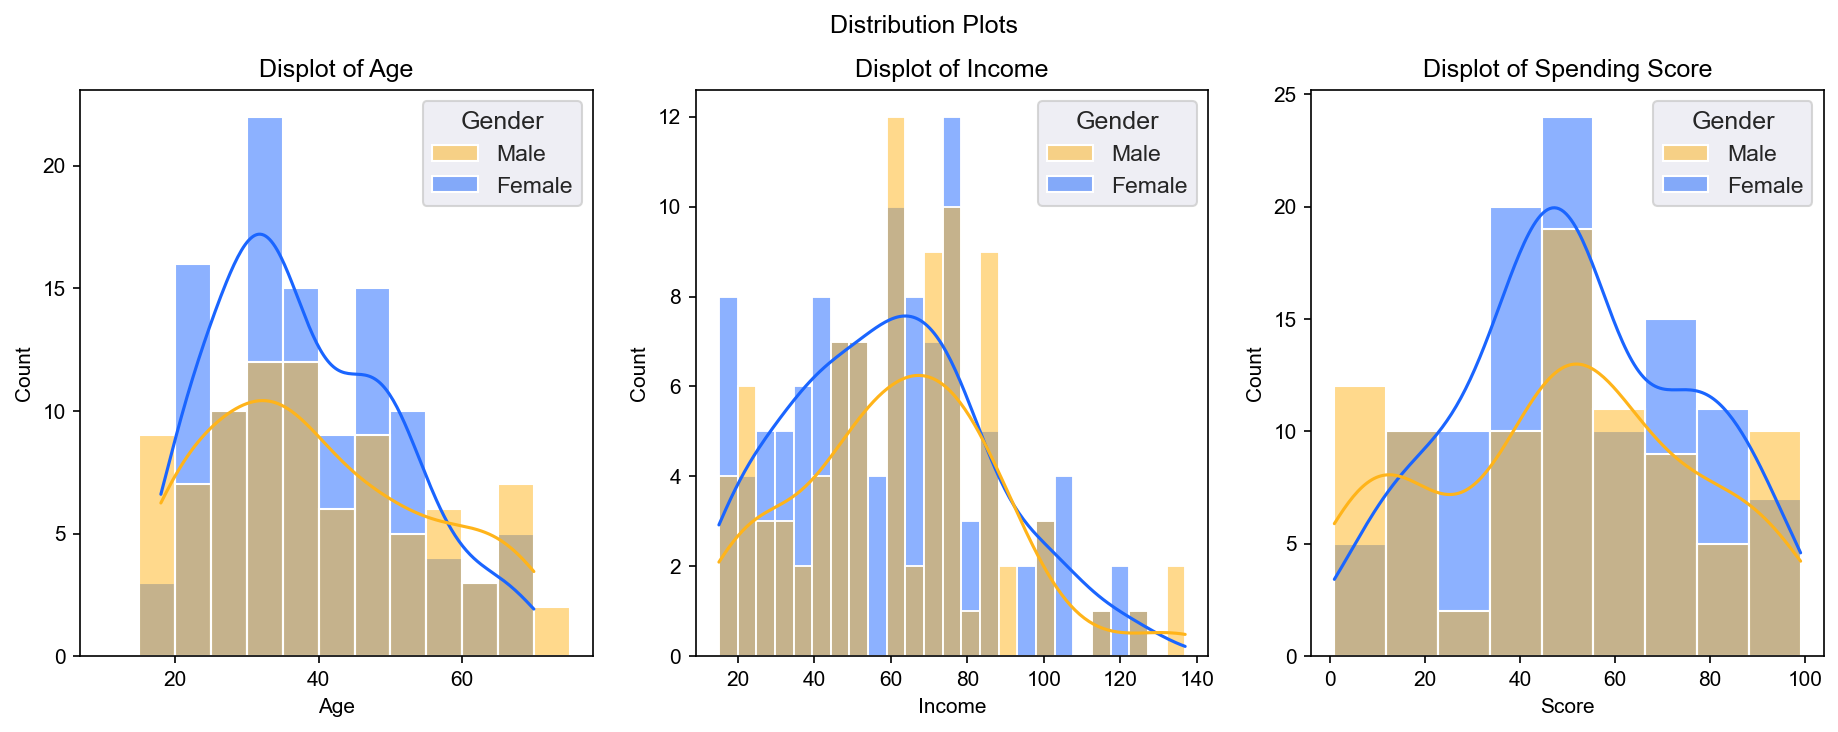

In [7]:
# looking at the distribution of the data across age income and spending score colored by gender
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)
fig.suptitle('Distribution Plots')
age_bins = range(10,80,5)
sns.set_theme(style="darkgrid")

# Age
sns.histplot(data=df, x="Age",ax=axes[0], bins=age_bins,palette=['#ffb41a','#1a65ff'], kde='TRUE', hue='Gender')
axes[0].set_title('Displot of Age')

# Income
sns.histplot(data=df, x="Income",ax=axes[1], bins=25,palette=['#ffb41a','#1a65ff'], kde='TRUE', hue='Gender')
axes[1].set_title('Displot of Income')

# Score
sns.histplot(data=df, x="Score",ax=axes[2], palette=['#ffb41a','#1a65ff'], kde='TRUE', hue='Gender')
axes[2].set_title('Displot of Spending Score');
#plt.xlim(0,200)


From the plote above we can see:
- The largest age groups are **20-30**, **30-40** and **40-50** with the **second** group having the most customers also **females** count lead in these groups. </br>

- Most customers earn an income between **`$50,000`**  and **`$80,000`** yearly. There seems to be outlier males earning \\$135,000.  </br>

- Men lead spending scores (0-30], Women lead spending scores (30-70] and women slightly edge men out in scores (70-100]. Most spending scores were between **30 and 50** for both genders.


In [8]:
# quickly check the total means of each category based on gender
df.groupby(['Gender']).mean()

CustomerID        Age     Income      Score
Gender                                             
Female   97.562500  38.098214  59.250000  51.526786
Male    104.238636  39.806818  62.227273  48.511364

We can see that males have the higher average age and also the higher income but females have the higher spending score.

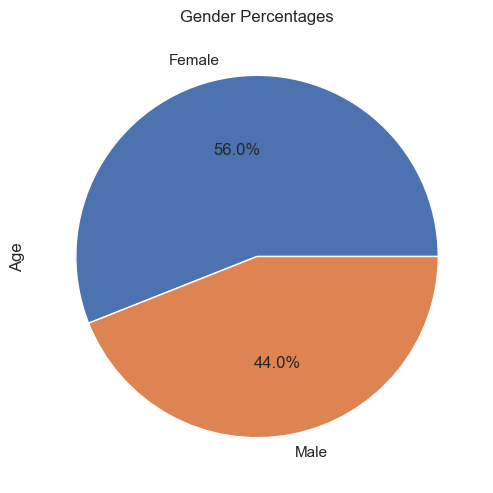

In [9]:
# gender percentages
plt.figure(figsize=(12,6), dpi =100)
mf_df = df.groupby(['Gender'])['Age'].count()
plt.title('Gender Percentages')
mf_df.plot.pie(y='Gender',autopct="%.1f%%");

From the plot above we can see that we have more females in the data than males

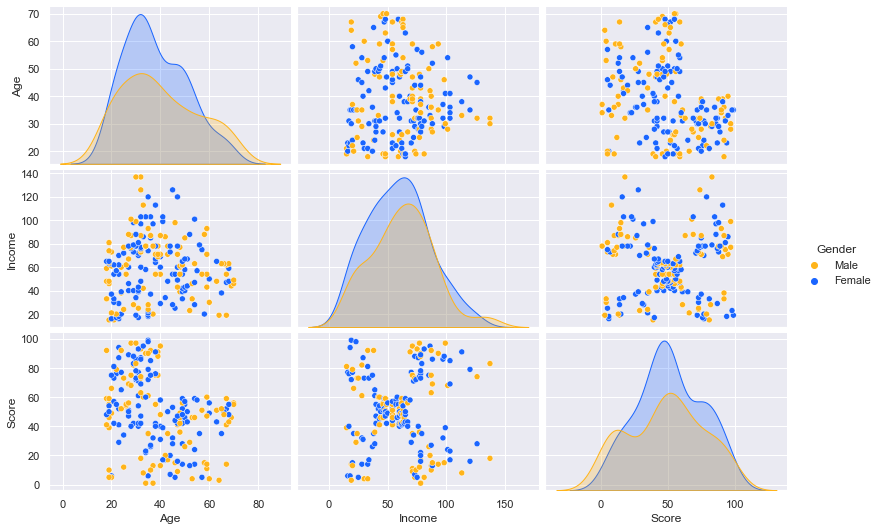

In [10]:
# Let's see our data in a detailed way with pairplot
#X = df.drop(['CustomerID', 'Gender'], axis=1)
sns.pairplot(df.drop('CustomerID', axis=1), hue='Gender',palette=['#ffb41a','#1a65ff'], aspect=1.5)
plt.show()

We can see from the above plots that it seems there is not much difference between male and female customers. It somewhat indicates that gender might not play a large role in developing clusters. In order to confirm this we will conduct a two sample t-test on gender.

 ### Kolmogorov-Smirnov 2Sample test 

In [11]:
# Kolmogorov-Smirnov 2Samp test ~> https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp
m_age = df[df['Gender']=='Male']['Age'] # collect males ages
f_age = df[df['Gender']=='Female']['Age'] # collect female ages 
KS_test = stats.ks_2samp(m_age, f_age, alternative='two-sided', mode='auto') # conduct the test
print('The Kolmogorov-Smirnov 2-Sample test gave p-value of {:.2} and therefore it confirms that the'
      ' difference between the genders in terms of age is not statistically significant.'.format(KS_test[1]))

The Kolmogorov-Smirnov 2-Sample test gave p-value of 0.49 and therefore it confirms that the difference between the genders in terms of age is not statistically significant.


In [12]:
# segment genders into 5 year age groups and calculate the means of each segment
age_bins = range(15,75,5)
means_by_age_group = df.groupby(["Gender",pd.cut(df['Age'], age_bins)]).mean()
means_by_age_group.index = means_by_age_group.index.set_names(['Gender', 'Age_group'])
means_by_age_group.reset_index(inplace=True)
means_by_age_group

Gender Age_group  CustomerID        Age     Income      Score
0   Female  (15, 20]   77.200000  19.200000  49.200000  46.600000
1   Female  (20, 25]   59.533333  22.600000  42.200000  62.666667
2   Female  (25, 30]  112.642857  28.714286  63.357143  68.571429
3   Female  (30, 35]  104.173913  32.782609  61.869565  62.260870
4   Female  (35, 40]  131.166667  37.750000  74.083333  51.916667
5   Female  (40, 45]  118.777778  43.333333  71.444444  29.222222
6   Female  (45, 50]   85.562500  48.375000  55.562500  38.500000
7   Female  (50, 55]  102.000000  53.000000  61.714286  37.285714
8   Female  (55, 60]   92.400000  58.200000  54.800000  32.000000
9   Female  (60, 65]   79.000000  64.000000  51.500000  39.000000
10  Female  (65, 70]   82.250000  67.250000  54.250000  51.250000
11    Male  (15, 20]   82.750000  19.000000  51.916667  43.833333
12    Male  (20, 25]   53.833333  23.500000  39.000000  64.833333
13    Male  (25, 30]  139.700000  27.900000  80.000000  73.600000
14    Male  (30, 35]  127.230769  33.076923  75.307692  56.846154
15    Male  (35, 40]  126.333333  38.250000  68.916667  54.666667
16    Male  (40, 45]  148.333333  42.666667  78.333333  24.000000
17    Male  (45, 50]  110.800000  47.900000  65.000000  35.600000
18    Male  (50, 55]   55.000000  53.000000  41.250000  31.250000
19    Male  (55, 60]  103.714286  58.714286  61.857143  28.857143
20    Male  (60, 65]   61.666667  64.000000  43.333333  35.333333
21    Male  (65, 70]   75.750000  68.000000  50.000000  45.250000

It is more appropriate to visualize the data seen above to gain insights

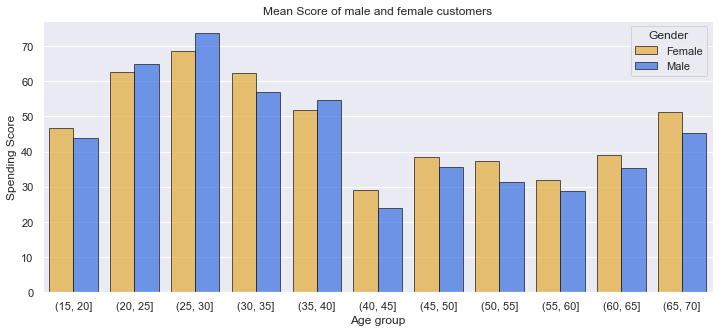

In [13]:
# plotting the mean score values
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Score',palette=['#ffb41a','#1a65ff'], hue='Gender', data=means_by_age_group,
            alpha=0.7,edgecolor='k',ax=ax)
ax.set_title('Mean Score of male and female customers')
ax.set_ylabel('Spending Score')
ax.set_xlabel('Age group')
plt.show()

- We can see from the plot above that the highest spendings scores tend to occur between ages **15** and **40**. 
- The absolute highest spending score for both genders occured in the age group **25** to **30** years old with males leading.
- Out of the 11 different age groups females lead males in 8 of these groups. It is interesting to note that after 40 years old females lead in spending score for every age group.

Based on the results above we can try to place our customers into 1 of three groups
1. Low Spenders: score less than 35
2. Medium Spenders: score between 35 and 60
3. High spenders: score above 60

In [14]:
# define a function that inputs the spending groups as classified above into a new column in our mean table
def spending_group(score):
    if score <= 35:
        return 'Low'
    if score > 35 and score <= 60:
        return 'Medium'
    if score > 60:
        return 'High'
means_by_age_group['Spending_Group'] = means_by_age_group['Score'].apply(spending_group)
means_by_age_group

Gender Age_group  CustomerID        Age     Income      Score  \
0   Female  (15, 20]   77.200000  19.200000  49.200000  46.600000   
1   Female  (20, 25]   59.533333  22.600000  42.200000  62.666667   
2   Female  (25, 30]  112.642857  28.714286  63.357143  68.571429   
3   Female  (30, 35]  104.173913  32.782609  61.869565  62.260870   
4   Female  (35, 40]  131.166667  37.750000  74.083333  51.916667   
5   Female  (40, 45]  118.777778  43.333333  71.444444  29.222222   
6   Female  (45, 50]   85.562500  48.375000  55.562500  38.500000   
7   Female  (50, 55]  102.000000  53.000000  61.714286  37.285714   
8   Female  (55, 60]   92.400000  58.200000  54.800000  32.000000   
9   Female  (60, 65]   79.000000  64.000000  51.500000  39.000000   
10  Female  (65, 70]   82.250000  67.250000  54.250000  51.250000   
11    Male  (15, 20]   82.750000  19.000000  51.916667  43.833333   
12    Male  (20, 25]   53.833333  23.500000  39.000000  64.833333   
13    Male  (25, 30]  139.700000  27.900000  80.000000  73.600000   
14    Male  (30, 35]  127.230769  33.076923  75.307692  56.846154   
15    Male  (35, 40]  126.333333  38.250000  68.916667  54.666667   
16    Male  (40, 45]  148.333333  42.666667  78.333333  24.000000   
17    Male  (45, 50]  110.800000  47.900000  65.000000  35.600000   
18    Male  (50, 55]   55.000000  53.000000  41.250000  31.250000   
19    Male  (55, 60]  103.714286  58.714286  61.857143  28.857143   
20    Male  (60, 65]   61.666667  64.000000  43.333333  35.333333   
21    Male  (65, 70]   75.750000  68.000000  50.000000  45.250000   

   Spending_Group  
0          Medium  
1            High  
2            High  
3            High  
4          Medium  
5             Low  
6          Medium  
7          Medium  
8             Low  
9          Medium  
10         Medium  
11         Medium  
12           High  
13           High  
14         Medium  
15         Medium  
16            Low  
17         Medium  
18            Low  
19            Low  
20         Medium  
21         Medium

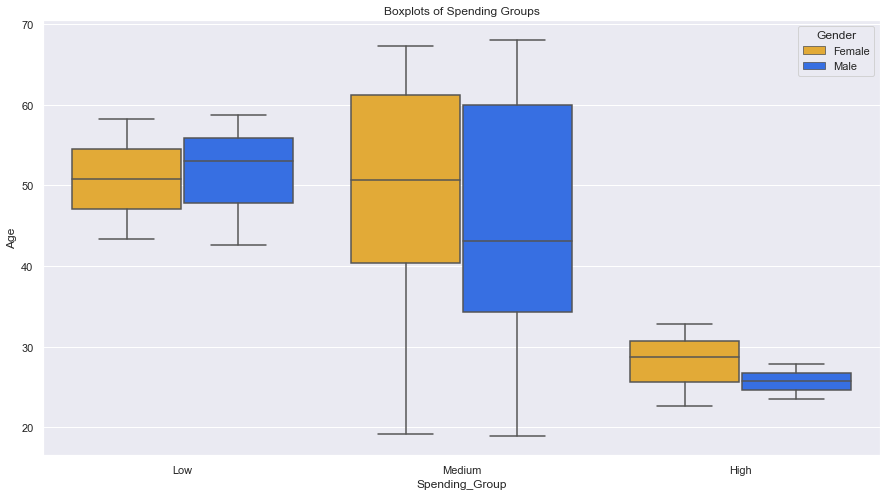

In [15]:
# investigate the spread of our score groups across age with boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(data=means_by_age_group, x='Spending_Group', y='Age',palette=['#ffb41a','#1a65ff'], 
            hue='Gender', order=['Low', 'Medium', 'High']);
plt.title('Boxplots of Spending Groups');
#plt.ylim(5,70)

- The highest variation for both males and females happened with the Medium spending group (ages 20-70)
- The smallest variation for both males and females happened with the High spending group (ages 25-35)
- Its also interesting that the low spending group has the highest median age of all spending groups.

In [16]:
# investigating the median annual income of of each gender and age 5 year age segments
age_bins = range(15,75,5)
medians_by_age_group = df.groupby(["Gender",pd.cut(df['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)
medians_by_age_group;

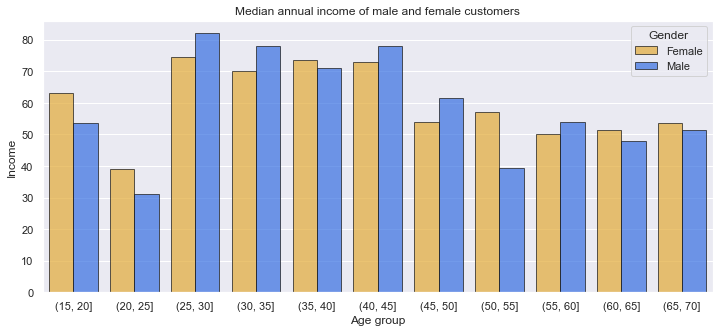

In [17]:
# plotting the medium annual income
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Income',palette=['#ffb41a','#1a65ff'], hue='Gender', data=medians_by_age_group,
            alpha=0.7,edgecolor='k',ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

- We can see from the bar chart above that the highest median income for both male and females occur in the **25** to **30** age group.
- Interestingly the lowest medium annual income for both genders occured in the **20** to **25** age group, which is the group right before the the highest annual median income group.
- The largest difference in median annual income between males and females occured in the **50** to **55** age group.
- Women lead in 6 of the income age groups and men lead in **5** of the income age groups.

Lets introduce some income brackets
1. Low Earners: income less than 50k
2. Medium Earners: income between 50k and 70k
3. High Earners: score above 70k


In [18]:
# define a function that inputs the income brackets as classified above into a new column in our median table
def income_brackets(income):
    if income <= 50:
        return 'Low'
    if income > 50 and income <= 70:
        return 'Medium'
    if income > 70:
        return 'High'
medians_by_age_group['Income_Group'] = medians_by_age_group['Income'].apply(income_brackets)
medians_by_age_group;

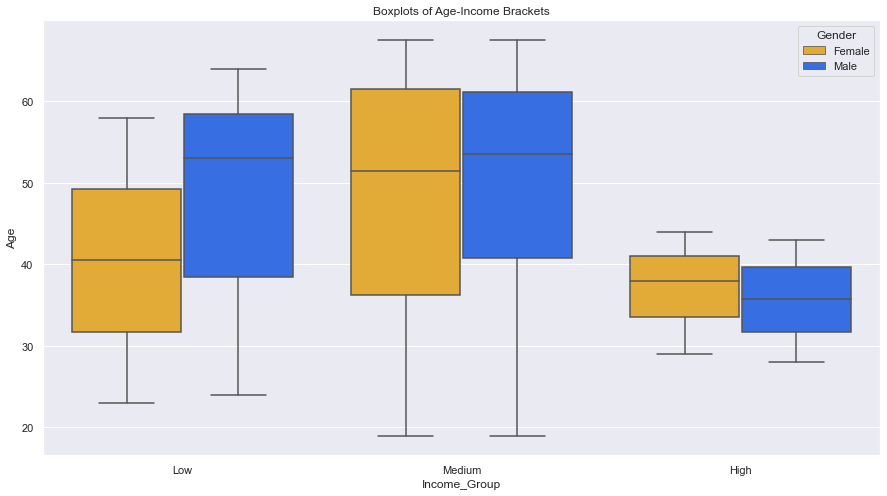

In [19]:
# investigate the spread of our income brackets across age with boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(data=medians_by_age_group, x='Income_Group', y='Age',palette=['#ffb41a','#1a65ff'], 
            hue='Gender', order=['Low', 'Medium', 'High']);
plt.title('Boxplots of Age-Income Brackets');


- The highest variation for both males and females happened with the Medium income group (ages 20-70)
- The smallest variation for both and females happened with the High income group (ages 25-45)
- Its also interesting that for males in low and medium income group had similar medians for their annual income.

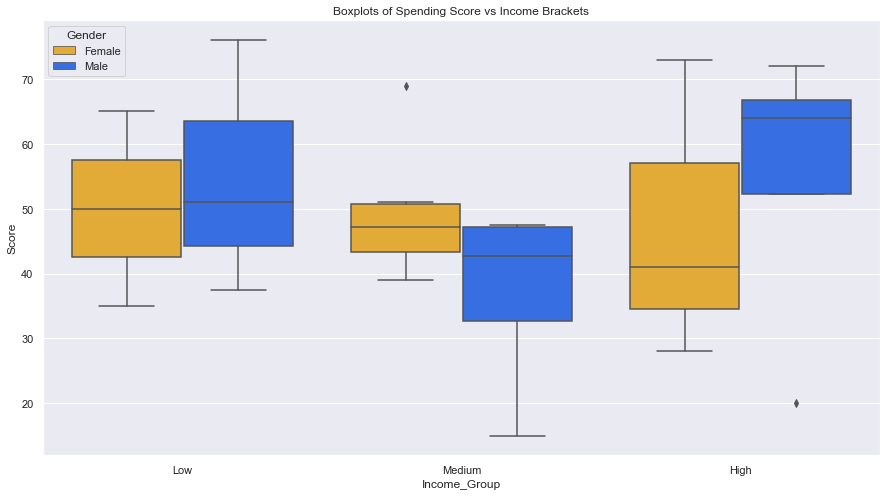

In [20]:
# investiagting the Spending score vs Income group 
plt.figure(figsize=(15, 8))
sns.boxplot(data=medians_by_age_group, x='Income_Group', y='Score',palette=['#ffb41a','#1a65ff'], 
            hue='Gender', order=['Low', 'Medium', 'High']);
plt.title('Boxplots of Spending Score vs Income Brackets');


- The highest spending score for males occured in the low income group whereas the highest spending score for females occured in the high income group.
- the highest median spending score for males occured in high income group whereas the highest female median spending score occured in the low income group.
- The medium income group had the smallest overall spending score.
- it is inteteresting to note that there were two outliers:
     - A high spending score female from the medium income group
     - A low spending score male from the high income group

## Data Pre-processing

### Dealing with categorical data columns
Here we have two issues to address, we have to transform our categorical data values into numerical values and then we have to scale our data. Scaling our data means that we are normalizing the range of the features of our data as a means to combat the large range of values in our raw data. 

In [21]:
df.head()

CustomerID  Gender  Age  Income  Score
0           1    Male   19      15     39
1           2    Male   21      15     81
2           3  Female   20      16      6
3           4  Female   23      16     77
4           5  Female   31      17     40

In [22]:
# Transforming categorical variables to dummy variables
df=df.drop("CustomerID", axis=1) # drop customer Id we dont need it for clustering
X = pd.get_dummies(df)
X.head()

Age  Income  Score  Gender_Female  Gender_Male
0   19      15     39              0            1
1   21      15     81              0            1
2   20      16      6              1            0
3   23      16     77              1            0
4   31      17     40              1            0

In [23]:
# Scaling our data using Standard Scaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

## Build and Evaluate Models

### K-Means Clustering
k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. k-means clustering minimizes within-cluster variances (squared Euclidean distances), but not regular Euclidean distances, which would be the more difficult Weber problem: the mean optimizes squared errors, whereas only the geometric median minimizes Euclidean distances. For instance, better Euclidean solutions can be found using k-medians and k-medoids.

In [24]:
#help(KMeans) ~> documentation

In [25]:
# applying KMeans to scaled data
KM_model = KMeans(n_clusters=2)

In [26]:
# applying fit_transform to scaled data
cluster_labels = KM_model.fit_predict(scaled_X)
cluster_labels # shows the cluster assignments

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0])

In [27]:
# Attaching the clusters to our temp dataframe
temp = X
temp['Cluster'] = cluster_labels
temp

Age  Income  Score  Gender_Female  Gender_Male  Cluster
0     19      15     39              0            1        0
1     21      15     81              0            1        0
2     20      16      6              1            0        1
3     23      16     77              1            0        1
4     31      17     40              1            0        1
..   ...     ...    ...            ...          ...      ...
195   35     120     79              1            0        1
196   45     126     28              1            0        1
197   32     126     74              0            1        0
198   32     137     18              0            1        0
199   30     137     83              0            1        0

[200 rows x 6 columns]

In [28]:
# Checking the correlation between features
temp.corr()

Age    Income     Score  Gender_Female  Gender_Male  \
Age            1.000000 -0.012398 -0.327227      -0.060867     0.060867   
Income        -0.012398  1.000000  0.009903      -0.056410     0.056410   
Score         -0.327227  0.009903  1.000000       0.058109    -0.058109   
Gender_Female -0.060867 -0.056410  0.058109       1.000000    -1.000000   
Gender_Male    0.060867  0.056410 -0.058109      -1.000000     1.000000   
Cluster       -0.060867 -0.056410  0.058109       1.000000    -1.000000   

                Cluster  
Age           -0.060867  
Income        -0.056410  
Score          0.058109  
Gender_Female  1.000000  
Gender_Male   -1.000000  
Cluster        1.000000

In [29]:
# Checking the correlation between features and Cluster assignments
temp.corr()['Cluster'].sort_values()

Gender_Male     -1.000000
Age             -0.060867
Income          -0.056410
Score            0.058109
Gender_Female    1.000000
Cluster          1.000000
Name: Cluster, dtype: float64

So we can see based on the sorted values what features are being considered for the clustering. We can plot this below.

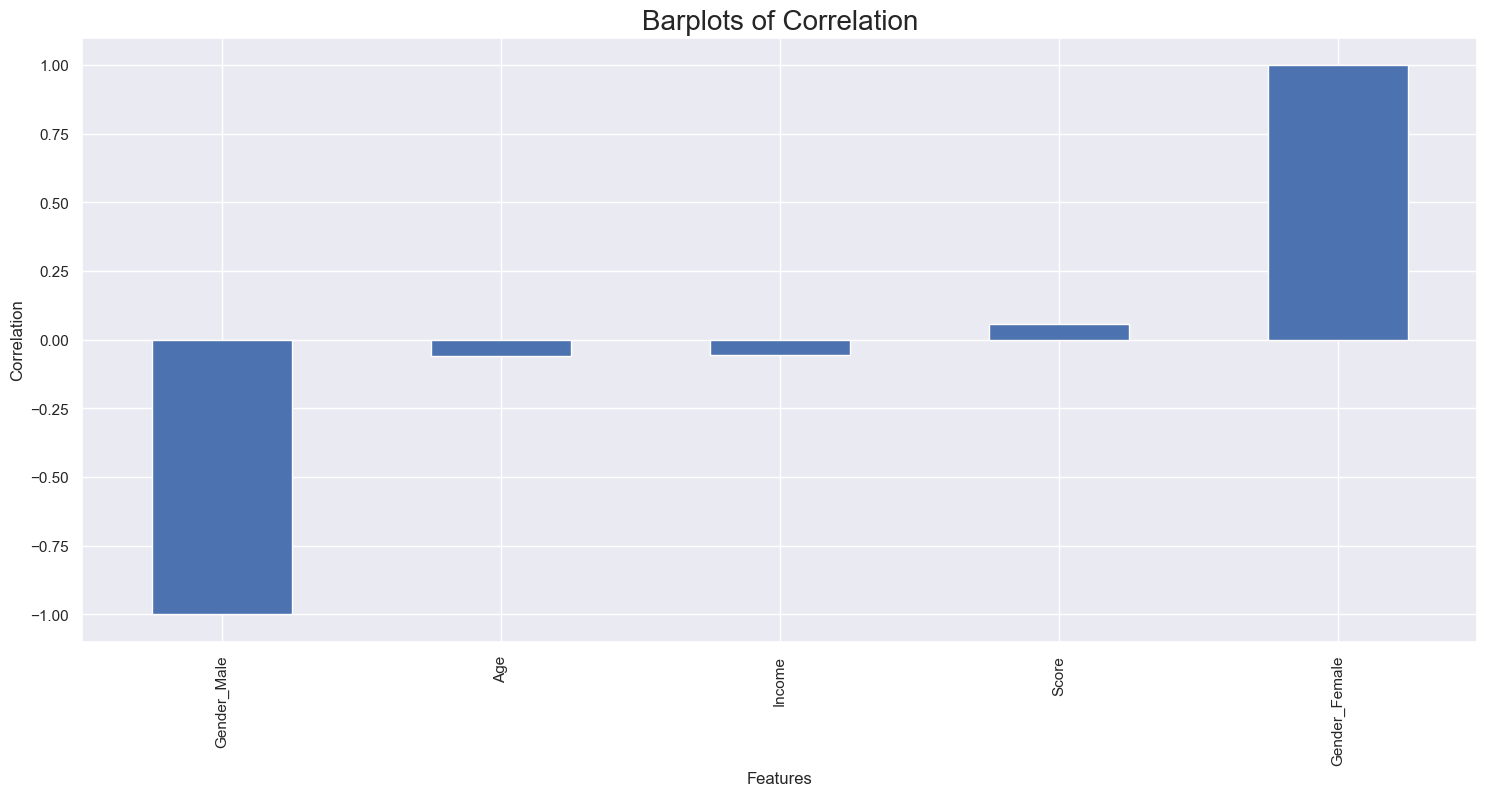

In [30]:
# Barplot of Correlations
plt.figure(figsize=(18,8),dpi=100)
cluster_corr_plot = temp.corr()['Cluster'].iloc[:-1].sort_values().plot(kind='bar')
plt.title('Barplots of Correlation', fontsize = 20)
plt.xlabel('Features')
plt.ylabel('Correlation');

### Determining the Ideal number of Clusters in the dataset
When determining the number of clusters to use one of the important methods is using what is known as the _Elbow Curve Method_ This method involves plotting the explained variance( Sum of Squared Distance) vs the Number of clusters (k) and choosing the number of clusters based on where the 'elbow' occurs. The elbow is the cutoff point at which increasing the number of clusters is no longer worth it.

In [31]:
# Elbow Curve Method
SSD = [] # this will collect the Sum of Sqaured Distances of a point to it assigned cluster center 

for cluster in range(2,12):
    
    KM_model = KMeans(n_clusters = cluster)
    KM_fit = KM_model.fit(scaled_X)
    SSD.append(KM_fit.inertia_)


In [32]:
# checking values
SSD

[597.9472937932284,
 488.1952688524801,
 386.82842558376643,
 331.37863922292763,
 289.71792822000475,
 239.10721742326572,
 199.75046112065573,
 174.19309570857695,
 152.6470392967239,
 141.02151862624842]

Text(0.5, 1.0, 'Elbow Plot')

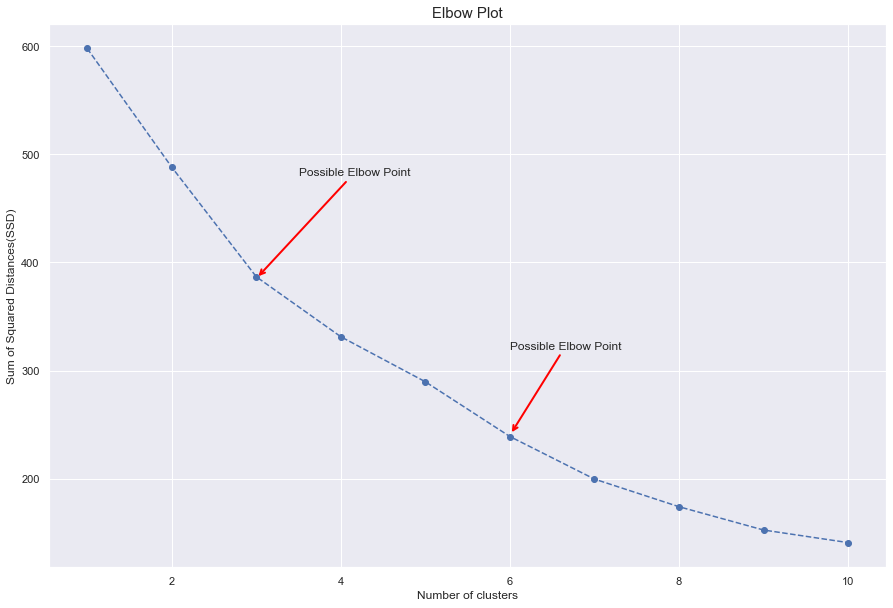

In [33]:
# store SSD values in data frame and plotting
SSD_data = pd.DataFrame({'Cluster':range(1,11), 'SSD':SSD})
plt.figure(figsize=(15,10))
plt.plot(SSD_data['Cluster'], SSD_data['SSD'], 'o--')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances(SSD)')
plt.annotate('Possible Elbow Point', xy=(3.01, 386), xytext=(3.5, 480), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red', lw=2))
plt.annotate('Possible Elbow Point', xy=(6.01,241.5), xytext=(6, 320), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red', lw=2))
plt.title('Elbow Plot', fontsize = 15)

In [34]:
# store SSD values as a series so we can do some calcualtions
pd.Series(SSD)

0    597.947294
1    488.195269
2    386.828426
3    331.378639
4    289.717928
5    239.107217
6    199.750461
7    174.193096
8    152.647039
9    141.021519
dtype: float64

In [35]:
# calculate difference betwwen a row and its previous row
pd.Series(SSD).diff()

0           NaN
1   -109.752025
2   -101.366843
3    -55.449786
4    -41.660711
5    -50.610711
6    -39.356756
7    -25.557365
8    -21.546056
9    -11.625521
dtype: float64

It was not easy to see from th graph where exactly the 'elbow' occured, therfore after calculating the difference bewteen each row and the one before it we can see that at index 2 we see the first significant drop and also at index 5 we see another comparatively significant drop. The indexes 2 and 5 corresponds with a K value of 3 and 6 respectively.

## Silhouette Score
Now that we know our ideal number of clusters (6) we can now apply a method to interpret our clusters. The Silhouette method allows
us to validate the consistency of our cluster data. The Silhouette score is a measure of how similar an feature is to its 
own cluster compaared the other clusters that exist. It ranges from -1 to 1. A high value indicates that a feature is closely 
alligned to its own cluster and poorly matched to any neighbouring cluster. Therefore if most of our features have a high value or 
positive it means our clustering model is well suited to the data but if many of our features have a low value or n=egative value
it means our clustering model is not suited appropriately to our data and we need to tinker with the number of clusters.

In [36]:
# Building a model to test various K values to compare with our ideal k = 6
#help(silhouette_score) ~> documentation
k_range = [2, 3, 4, 5, 6, 7]
for k in k_range:
    KM_model = KMeans(n_clusters = k, max_iter = 35)
    KM_fit = KM_model.fit(scaled_X)
    
    # Applying Silhouette Score
    silh_vals = silhouette_score(scaled_X, KM_fit.labels_)
    
    # print out the scores for each cluster
    print('When we have {0} clusters, the Silhouette Score is {1}'.format(k,silh_vals))

When we have 2 clusters, the Silhouette Score is 0.39644160577705434
When we have 3 clusters, the Silhouette Score is 0.36782472313835896
When we have 4 clusters, the Silhouette Score is 0.33269643434208473
When we have 5 clusters, the Silhouette Score is 0.34571517088794623
When we have 6 clusters, the Silhouette Score is 0.3579439098923205
When we have 7 clusters, the Silhouette Score is 0.38075477170175814


We can see that from the Silhouette scores caslculated above we can confirm that k=3 and k=6 are indeed good candidates for the number of clusters to use in KMeans clustering. For clarification, even though we can see that having 2,7 or 8 clusters yielded higher Silhouette scores, I believe just two clusters are not enough to obtain meaningful insights from the data and having seven or more clusters might be overkill for this dataset that only has 4 features. Now we need to visualize the clusters.

Text(0.5, 1.0, 'Scatter Plot Of Clusters')

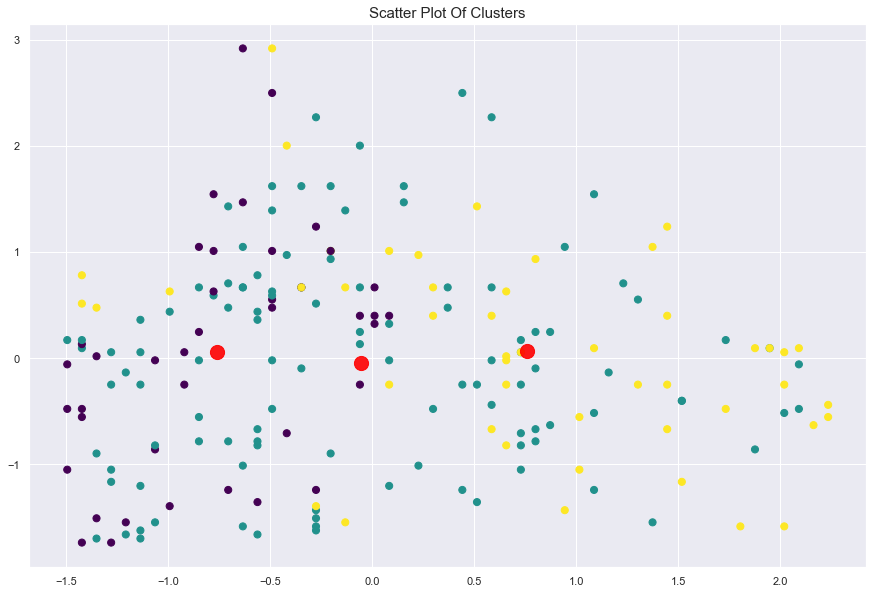

In [37]:
# PLotting k=3 Clusters
KM_model = KMeans(n_clusters=3)
KM_model.fit(scaled_X)
y_kmeans = KM_model.predict(scaled_X) # predicted y vals
KM3_clusters = KM_model.labels_ # store the clusters
plt.figure(figsize=(15,10))
plt.scatter(scaled_X[:, 0], scaled_X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = KM_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9); # plot and color cluster centers
plt.title('Scatter Plot Of Clusters', fontsize = 15)

We can see from the Graph plotted above that we have some degree of separation of the different clusters. I have also plotted each cluster center as red. This is not too easily visualized as seen above so we will plot a 3D visual below.

In [38]:
# PLotting a 3D model of  k=3 Clusters
import plotly.express as px

fig = px.scatter_3d(
    X,
    x='Age', y='Score',z='Income', 
    color=KM3_clusters.astype(str), opacity=0.75, height=650, width=650,
    color_discrete_sequence=px.colors.qualitative.Set2,
    title='3D Cluster Plot of 3 Cluster Model for Age, SpendingScore and Income')
fig.show()
#fig.show("png")

We can see that this plot allows us greater ease with seeing the separation between the clusters. We can choose to dig a litter deeper to break the clusters into groups based on Score vs Income and Score vs Age.

In [39]:
X

Age  Income  Score  Gender_Female  Gender_Male  Cluster
0     19      15     39              0            1        0
1     21      15     81              0            1        0
2     20      16      6              1            0        1
3     23      16     77              1            0        1
4     31      17     40              1            0        1
..   ...     ...    ...            ...          ...      ...
195   35     120     79              1            0        1
196   45     126     28              1            0        1
197   32     126     74              0            1        0
198   32     137     18              0            1        0
199   30     137     83              0            1        0

[200 rows x 6 columns]

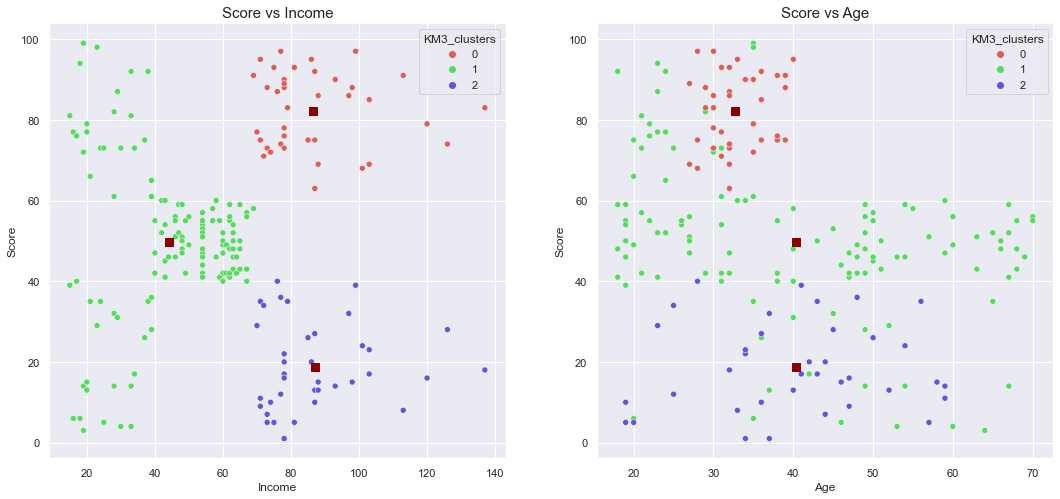

In [40]:
# 3 cluster Plots focusing on Score vs Income and Score vs Age
km3 = KMeans(n_clusters=3).fit(X)
X['KM3_clusters'] = km3.labels_

center00 = km3.cluster_centers_[:,1] #x
center01 = km3.cluster_centers_[:,2] #y

center10 = km3.cluster_centers_[:,0] #x
center11 = km3.cluster_centers_[:,2] #y

fig, axes = plt.subplots(1, 2, figsize=(18,8))
#plt.figure(figsize=(12, 8))
sns.scatterplot(data=X, x="Income", y='Score', hue='KM3_clusters', 
                palette=sns.color_palette('hls', 3), ax= axes[0])
sns.scatterplot(data=X, x="Age", y='Score', hue='KM3_clusters', 
                palette=sns.color_palette('hls', 3), ax= axes[1])

axes[0].scatter(center00,center01, marker='s', s=50, c="darkred") # plot center for Score vs Income
axes[1].scatter(center10,center11, marker='s', s=50, c="darkred") # plot center for Score vs Age


#fig.suptitle('Cluster Breakdowns')
axes[0].set_title('Score vs Income',fontsize=15)
axes[1].set_title('Score vs Age',fontsize=15)
plt.show(); 

 The plots above show three clear distinct groups in each plot. This can be viewed as a swarm plot for us to tease out our insights more clearly.

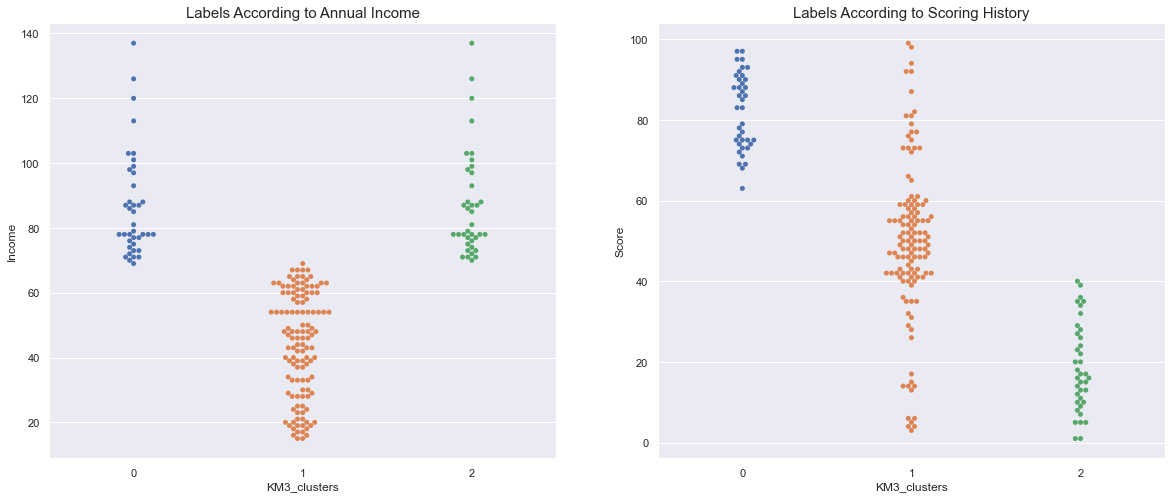

In [41]:
# Swarm plot to help visualize clusters
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
sns.swarmplot(x='KM3_clusters', y='Income', data=X, ax=ax)
ax.set_title('Labels According to Annual Income',fontsize=15)

ax = fig.add_subplot(122)
sns.swarmplot(x='KM3_clusters', y='Score', data=X, ax=ax)
ax.set_title('Labels According to Scoring History',fontsize=15)

plt.show()

From our plots above we can detail each cluster as follows:
- Cluster 0 customers have high incomes and also a very high spending scores.
- Cluster 1 customers have low to medium income with the most varied spennding score with heavy clustering above a 50 spending score.
- Cluster 2 customers have high income with very low spending scores.

Stopping here might be enough depending on how a business might want to appeal to or address their customers but I believe 
more granualrity or in this case more clusters might tease out even more insights for more specific targeting or tailoring to
the customer base.
From here I on I will focus on 6 Clusters for the analysis.

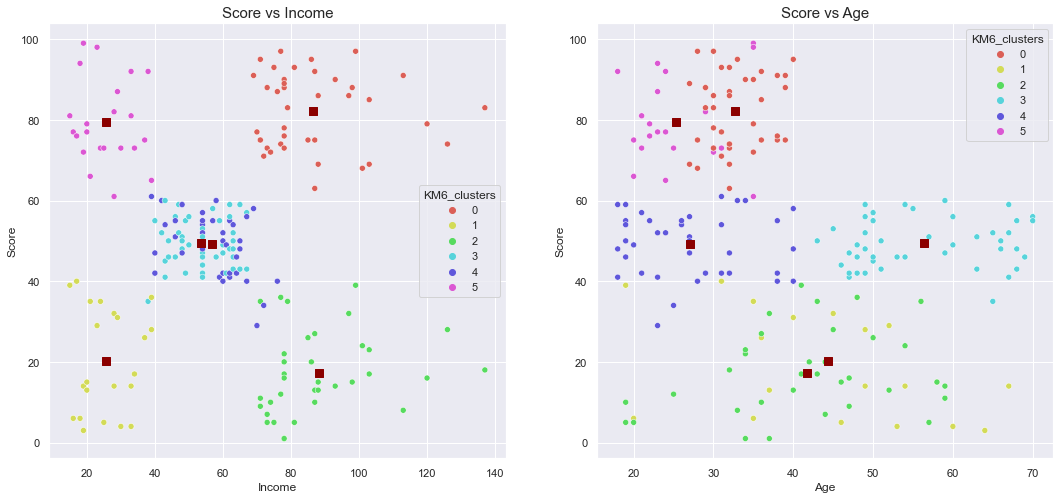

In [42]:
# 6 cluster Plots
km6 = KMeans(n_clusters=6).fit(X)
X['KM6_clusters'] = km6.labels_
KM6_clusters = km6.labels_

center00 = km6.cluster_centers_[:,1] #x
center01 = km6.cluster_centers_[:,2] #y

center10 = km6.cluster_centers_[:,0] #x
center11 = km6.cluster_centers_[:,2] #y

fig, axes = plt.subplots(1, 2, figsize=(18,8))
#plt.figure(figsize=(12, 8))
sns.scatterplot(data=X, x="Income", y='Score', hue='KM6_clusters', 
                palette=sns.color_palette('hls', 6), ax= axes[0])
sns.scatterplot(data=X, x="Age", y='Score', hue='KM6_clusters', 
                palette=sns.color_palette('hls', 6), ax= axes[1])

axes[0].scatter(center00,center01, marker='s', s=50, c="darkred") # plot center for Score vs Income
axes[1].scatter(center10,center11, marker='s', s=50, c="darkred") # plot center for Score vs Age


#fig.suptitle('Cluster Breakdowns')
axes[0].set_title('Score vs Income',fontsize=15)
axes[1].set_title('Score vs Age',fontsize=15)
plt.show();

In [43]:
# PLotting a 3D model of  k=3 Clusters
import plotly.express as px

fig = px.scatter_3d(
    X,
    x='Age', y='Score',z='Income', 
    color=KM6_clusters.astype(str), opacity=0.75, height=650, width=650,
    color_discrete_sequence=px.colors.qualitative.Set2,
    title='3D Cluster Plot of 6 Cluster Model for Age, SpendingScore and Income')
fig.show()


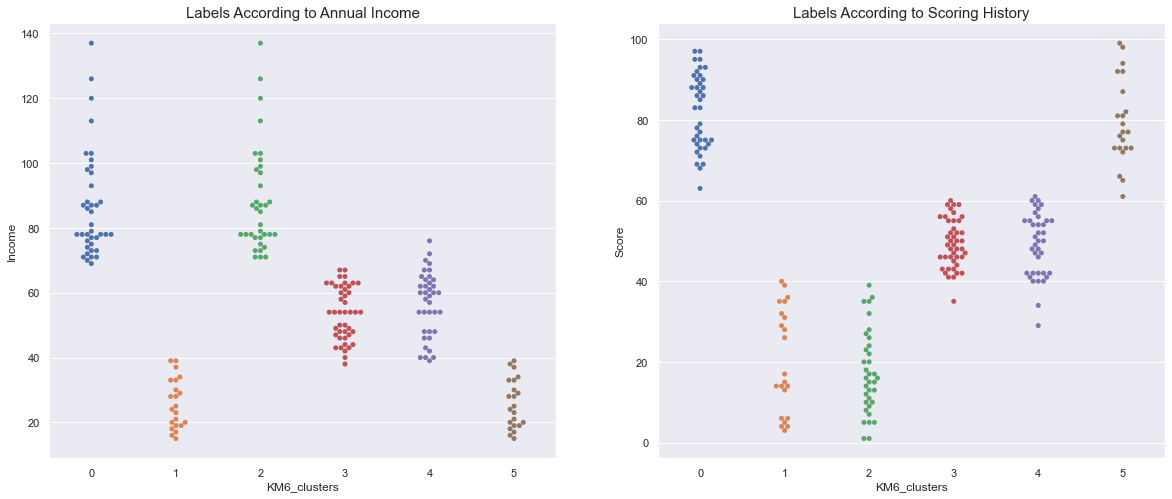

In [44]:
# Swarm plot to help visualize clusters
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
sns.swarmplot(x='KM6_clusters', y='Income', data=X, ax=ax)
ax.set_title('Labels According to Annual Income',fontsize=15)

ax = fig.add_subplot(122)
sns.swarmplot(x='KM6_clusters', y='Score', data=X, ax=ax)
ax.set_title('Labels According to Scoring History',fontsize=15)

plt.show()

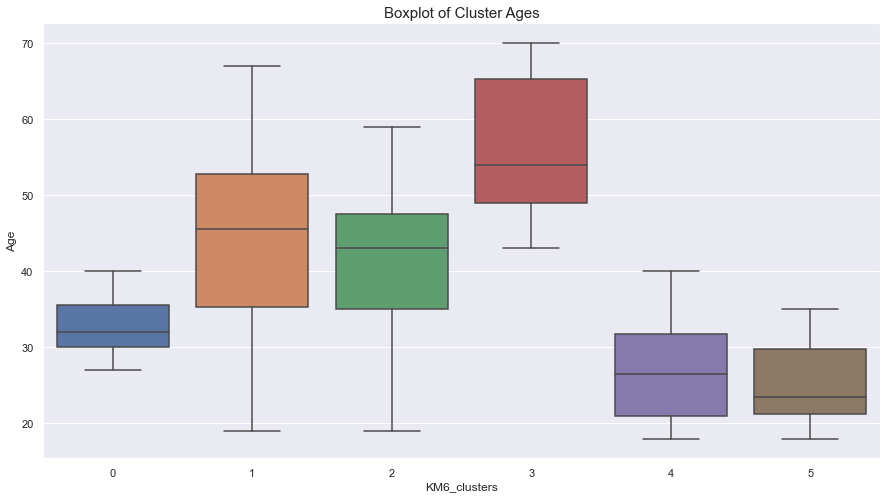

In [45]:
# doing a box plot to ascertain age insights based on clusters
plt.figure(figsize=(15, 8))
sns.boxplot(data=X, x='KM6_clusters', y='Age')
plt.title('Boxplot of Cluster Ages', fontsize = 15);

For the puporse of this part of the analysis customers were divided into the following age **young adulthood** (18 to 35 years),**middle age** (36 to 55 years), and **older adulthood** (56 years and older).</br> As a reminder I wont consider gender in the analysis as we conducted a  Kolmogorov-Smirnov 2Samp test which indicated that there is no statistical differences between the genders with this data.

From our plots above we can detail each cluster as follows:
- Cluster 0 customers are mainly young adults with high income and very high spending score.(most female dominated 54%)
- Cluster 1 customers are middle aged with low income and low spending scores.(most female dominated 59%)
- Cluster 2 customers are middle aged with high incomes and low spending scores. (male dominated 57%)
- Cluster 3 customers are older adults with medium income and medium spending scores.(most female dominated 57%) 
- Cluster 4 customers are young adults with medium income and medium spending scores.(most female dominated 66%) 
- Cluster 5 customers are young adults with very low incomes and very high spending scores. (most female dominated 59%)

We can view this more easily with a heat map of the clusters over our features.

In [46]:
# create a dataframe with original data attached with 6 cluster model cluster labels
cluster6_heatmap_df = df
cluster6_heatmap_df['KM6_clusters'] = km6.labels_ # attach labels
cluster6_heatmap_df

Gender  Age  Income  Score  KM6_clusters
0      Male   19      15     39             1
1      Male   21      15     81             5
2    Female   20      16      6             1
3    Female   23      16     77             5
4    Female   31      17     40             1
..      ...  ...     ...    ...           ...
195  Female   35     120     79             0
196  Female   45     126     28             2
197    Male   32     126     74             0
198    Male   32     137     18             2
199    Male   30     137     83             0

[200 rows x 5 columns]

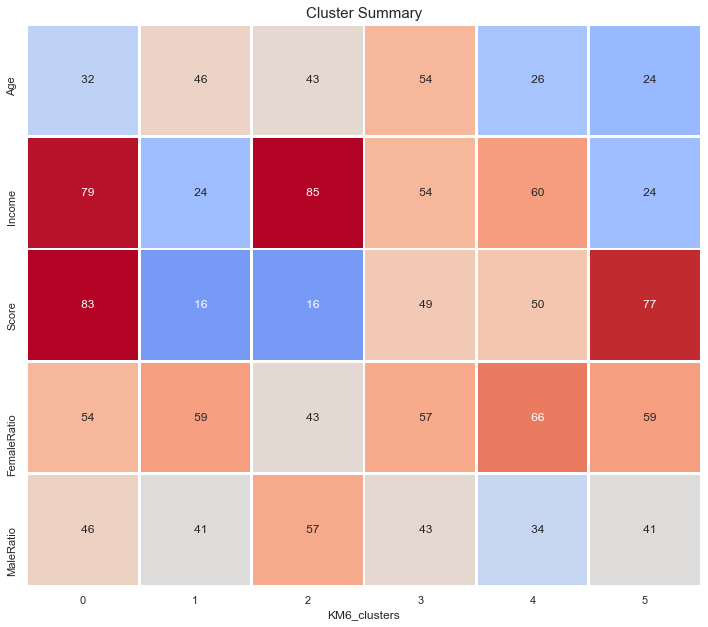

In [47]:
# aggregting our data over median values and computing male and female ratios
cluster_heatmap = cluster6_heatmap_df.groupby(['KM6_clusters'])[['Age', 'Income', 'Score']].median()
tot_gender = cluster6_heatmap_df.groupby(['KM6_clusters']).count()['Gender'] 
cluster_heatmap['FemaleRatio'] = cluster6_heatmap_df[cluster6_heatmap_df['Gender'] == 'Female'].groupby(['KM6_clusters']).count()['Gender'] / tot_gender * 100
cluster_heatmap['MaleRatio'] = cluster6_heatmap_df[cluster6_heatmap_df['Gender'] == 'Male'].groupby(['KM6_clusters']).count()['Gender'] / tot_gender* 100

# Plotting heatmap.
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(cluster_heatmap.T, 
    square=True, linewidth=1.9, vmax=80, vmin=1,
    cmap="coolwarm", # another colour map YlGnBu
    cbar=False, annot=True,fmt='5.0f', ax=ax,
    #cbar_kws={"orientation": "horizontal"},
);
ax.set_title('Cluster Summary',fontsize = 15);
plt.tight_layout()

## Hierarchical Clustering
In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. In other words it is an algorithm that groups similar objects into groups called clusters. There are mainly two types

Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
Divisive: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

In this notebook we will use the Agglomerative approach.

In [48]:
scaled_X

array([[-1.42456879, -1.73899919, -0.43480148, -1.12815215,  1.12815215],
       [-1.28103541, -1.73899919,  1.19570407, -1.12815215,  1.12815215],
       [-1.3528021 , -1.70082976, -1.71591298,  0.88640526, -0.88640526],
       [-1.13750203, -1.70082976,  1.04041783,  0.88640526, -0.88640526],
       [-0.56336851, -1.66266033, -0.39597992,  0.88640526, -0.88640526],
       [-1.20926872, -1.66266033,  1.00159627,  0.88640526, -0.88640526],
       [-0.27630176, -1.62449091, -1.71591298,  0.88640526, -0.88640526],
       [-1.13750203, -1.62449091,  1.70038436,  0.88640526, -0.88640526],
       [ 1.80493225, -1.58632148, -1.83237767, -1.12815215,  1.12815215],
       [-0.6351352 , -1.58632148,  0.84631002,  0.88640526, -0.88640526],
       [ 2.02023231, -1.58632148, -1.4053405 , -1.12815215,  1.12815215],
       [-0.27630176, -1.58632148,  1.89449216,  0.88640526, -0.88640526],
       [ 1.37433211, -1.54815205, -1.36651894,  0.88640526, -0.88640526],
       [-1.06573534, -1.54815205,  1.0

In [49]:
# MinMaxScaler ~> no values should be greater than 1 or less than 0
mmscaler = MinMaxScaler()
mmscaled_data = mmscaler.fit_transform(X)
#X ~> Remember that X is the dataframe with the categoricals transformed to dummy variables

In [50]:
X

Age  Income  Score  Gender_Female  Gender_Male  Cluster  KM3_clusters  \
0     19      15     39              0            1        0             1   
1     21      15     81              0            1        0             1   
2     20      16      6              1            0        1             1   
3     23      16     77              1            0        1             1   
4     31      17     40              1            0        1             1   
..   ...     ...    ...            ...          ...      ...           ...   
195   35     120     79              1            0        1             0   
196   45     126     28              1            0        1             2   
197   32     126     74              0            1        0             0   
198   32     137     18              0            1        0             2   
199   30     137     83              0            1        0             0   

     KM6_clusters  
0               1  
1               5  
2               1  
3               5  
4               1  
..            ...  
195             0  
196             2  
197             0  
198             2  
199             0  

[200 rows x 8 columns]

In [51]:
mmscaled_data

array([[0.01923077, 0.        , 0.3877551 , ..., 0.        , 0.5       ,
        0.2       ],
       [0.05769231, 0.        , 0.81632653, ..., 0.        , 0.5       ,
        1.        ],
       [0.03846154, 0.00819672, 0.05102041, ..., 1.        , 0.5       ,
        0.2       ],
       ...,
       [0.26923077, 0.90983607, 0.74489796, ..., 0.        , 0.        ,
        0.        ],
       [0.26923077, 1.        , 0.17346939, ..., 0.        , 1.        ,
        0.4       ],
       [0.23076923, 1.        , 0.83673469, ..., 0.        , 0.        ,
        0.        ]])

In [52]:
# Converting it from array to dataframe
mmscaled_df = pd.DataFrame(mmscaled_data, columns= X.columns)
mmscaled_df

Age    Income     Score  Gender_Female  Gender_Male  Cluster  \
0    0.019231  0.000000  0.387755            0.0          1.0      0.0   
1    0.057692  0.000000  0.816327            0.0          1.0      0.0   
2    0.038462  0.008197  0.051020            1.0          0.0      1.0   
3    0.096154  0.008197  0.775510            1.0          0.0      1.0   
4    0.250000  0.016393  0.397959            1.0          0.0      1.0   
..        ...       ...       ...            ...          ...      ...   
195  0.326923  0.860656  0.795918            1.0          0.0      1.0   
196  0.519231  0.909836  0.275510            1.0          0.0      1.0   
197  0.269231  0.909836  0.744898            0.0          1.0      0.0   
198  0.269231  1.000000  0.173469            0.0          1.0      0.0   
199  0.230769  1.000000  0.836735            0.0          1.0      0.0   

     KM3_clusters  KM6_clusters  
0             0.5           0.2  
1             0.5           1.0  
2             0.5           0.2  
3             0.5           1.0  
4             0.5           0.2  
..            ...           ...  
195           0.0           0.0  
196           1.0           0.4  
197           0.0           0.0  
198           1.0           0.4  
199           0.0           0.0  

[200 rows x 8 columns]

In [53]:
# Dropping the cluster and labels column
mmscaled_df=mmscaled_df.drop(["KM3_clusters","KM6_clusters","Cluster"], axis=1)
mmscaled_df

Age    Income     Score  Gender_Female  Gender_Male
0    0.019231  0.000000  0.387755            0.0          1.0
1    0.057692  0.000000  0.816327            0.0          1.0
2    0.038462  0.008197  0.051020            1.0          0.0
3    0.096154  0.008197  0.775510            1.0          0.0
4    0.250000  0.016393  0.397959            1.0          0.0
..        ...       ...       ...            ...          ...
195  0.326923  0.860656  0.795918            1.0          0.0
196  0.519231  0.909836  0.275510            1.0          0.0
197  0.269231  0.909836  0.744898            0.0          1.0
198  0.269231  1.000000  0.173469            0.0          1.0
199  0.230769  1.000000  0.836735            0.0          1.0

[200 rows x 5 columns]

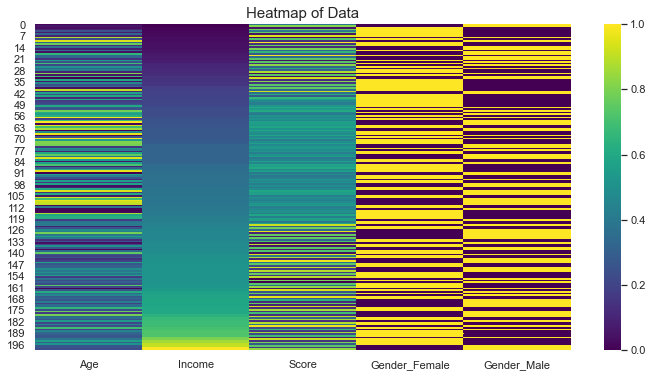

In [54]:
# Checking the data with a Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(mmscaled_df, cmap='viridis')
plt.title('Heatmap of Data', fontsize = 15);

In [55]:
# Import Hierarchial Clustering check ~> https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
from sklearn.cluster import AgglomerativeClustering

In [56]:
# create model for 6 clusters based on cluster results in K-Means
hc_model = AgglomerativeClustering(n_clusters=6)

In [57]:
# setting clusters labels to our scaled data
hc_clustlabels = hc_model.fit_predict(mmscaled_df)
hc_clustlabels

array([3, 2, 0, 1, 0, 1, 0, 1, 3, 1, 3, 1, 0, 1, 3, 2, 0, 2, 3, 1, 3, 2,
       0, 2, 0, 2, 0, 3, 0, 1, 3, 1, 3, 2, 0, 1, 0, 1, 0, 1, 0, 2, 3, 1,
       0, 1, 0, 1, 1, 1, 0, 3, 1, 3, 0, 3, 0, 3, 1, 3, 3, 2, 0, 0, 3, 2,
       0, 0, 2, 1, 3, 0, 0, 0, 3, 2, 0, 3, 1, 0, 3, 3, 3, 0, 1, 3, 0, 1,
       1, 0, 0, 2, 3, 1, 1, 2, 0, 1, 3, 2, 1, 0, 3, 2, 3, 1, 0, 3, 3, 3,
       3, 1, 1, 2, 1, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 5, 3, 2, 4, 2, 4, 2,
       1, 5, 4, 5, 0, 2, 4, 5, 0, 2, 1, 5, 4, 2, 3, 5, 0, 2, 4, 2, 0, 5,
       0, 5, 4, 5, 4, 5, 0, 5, 4, 5, 4, 5, 4, 5, 0, 2, 4, 2, 4, 2, 0, 5,
       4, 2, 4, 2, 0, 5, 4, 5, 0, 2, 0, 2, 0, 5, 0, 5, 4, 5, 0, 5, 0, 2,
       4, 2], dtype=int64)

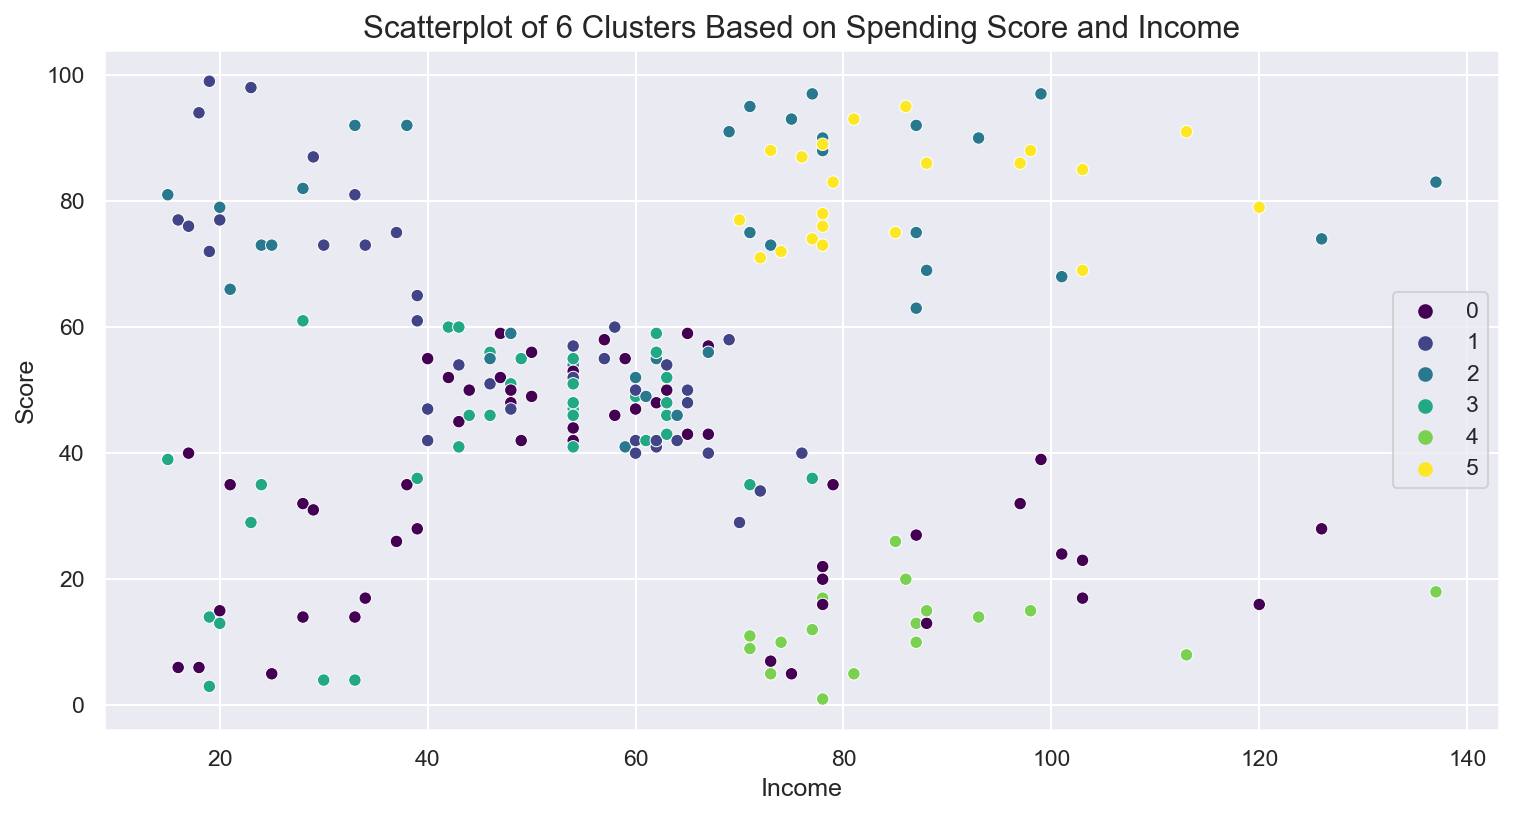

In [58]:
# visually checking clusters
plt.figure(figsize=(12,6), dpi = 150)
sns.scatterplot(data=df,x='Income', y='Score', hue=hc_clustlabels, palette='viridis')
plt.title('Scatterplot of 6 Clusters Based on Spending Score and Income', fontsize = 15);

In [59]:
# What is the max distance possible 
# sqrt(n_features)

In [60]:
mmscaled_df

Age    Income     Score  Gender_Female  Gender_Male
0    0.019231  0.000000  0.387755            0.0          1.0
1    0.057692  0.000000  0.816327            0.0          1.0
2    0.038462  0.008197  0.051020            1.0          0.0
3    0.096154  0.008197  0.775510            1.0          0.0
4    0.250000  0.016393  0.397959            1.0          0.0
..        ...       ...       ...            ...          ...
195  0.326923  0.860656  0.795918            1.0          0.0
196  0.519231  0.909836  0.275510            1.0          0.0
197  0.269231  0.909836  0.744898            0.0          1.0
198  0.269231  1.000000  0.173469            0.0          1.0
199  0.230769  1.000000  0.836735            0.0          1.0

[200 rows x 5 columns]

In [61]:
len(mmscaled_df.columns)

5

In [62]:
# Max theortical distance between two points
np.sqrt(66)

8.12403840463596

In [63]:
# New model based on distance threshold
new_model = AgglomerativeClustering(n_clusters=None, distance_threshold=2)

In [64]:
new_clustlabels = new_model.fit_predict(mmscaled_df)
new_clustlabels

array([3, 0, 2, 1, 2, 1, 2, 1, 3, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 1, 3, 0,
       2, 0, 2, 0, 2, 3, 2, 1, 3, 1, 3, 0, 2, 1, 2, 1, 2, 1, 2, 0, 3, 1,
       2, 1, 2, 1, 1, 1, 2, 3, 1, 3, 2, 3, 2, 3, 1, 3, 3, 0, 2, 2, 3, 0,
       2, 2, 0, 1, 3, 2, 2, 2, 3, 0, 2, 3, 1, 2, 3, 3, 3, 2, 1, 3, 2, 1,
       1, 2, 2, 0, 3, 1, 1, 0, 2, 1, 3, 0, 1, 2, 3, 0, 3, 1, 2, 3, 3, 3,
       3, 1, 1, 0, 1, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 5, 3, 0, 4, 0, 4, 0,
       1, 5, 4, 5, 6, 0, 4, 5, 6, 0, 1, 5, 4, 0, 3, 5, 6, 0, 4, 0, 6, 5,
       6, 5, 4, 5, 4, 5, 6, 5, 4, 5, 4, 5, 4, 5, 6, 0, 4, 0, 4, 0, 6, 5,
       4, 0, 4, 0, 6, 5, 4, 5, 6, 0, 6, 0, 6, 5, 6, 5, 4, 5, 6, 5, 6, 0,
       4, 0], dtype=int64)

In [65]:
# Visualing Linkages as a Dendogram
linkage_matrix = hierarchy.linkage(new_model.children_)
# Notes for matrix based on index 0= cluster 38, 1= cluster 76, 2= dist between clusters(1.414), 3 = # of points in that cluster(2)
linkage_matrix

array([[ 38.        ,  76.        ,   1.41421356,   2.        ],
       [  2.        , 151.        ,   1.41421356,   2.        ],
       [196.        , 197.        ,   1.41421356,   2.        ],
       [  9.        ,  10.        ,   2.23606798,   2.        ],
       [112.        , 117.        ,   2.23606798,   2.        ],
       [182.        , 183.        ,   2.23606798,   2.        ],
       [189.        , 192.        ,   2.23606798,   2.        ],
       [ 28.        ,  62.        ,   2.23606798,   2.        ],
       [ 52.        ,  69.        ,   2.82842712,   2.        ],
       [ 30.        ,  43.        ,   2.82842712,   2.        ],
       [ 95.        , 128.        ,   2.82842712,   2.        ],
       [ 41.        ,  84.        ,   2.82842712,   2.        ],
       [ 29.        ,  59.        ,   3.16227766,   2.        ],
       [  1.        ,  16.        ,   3.16227766,   2.        ],
       [ 40.        ,  56.        ,   3.16227766,   2.        ],
       [ 27.        ,  32

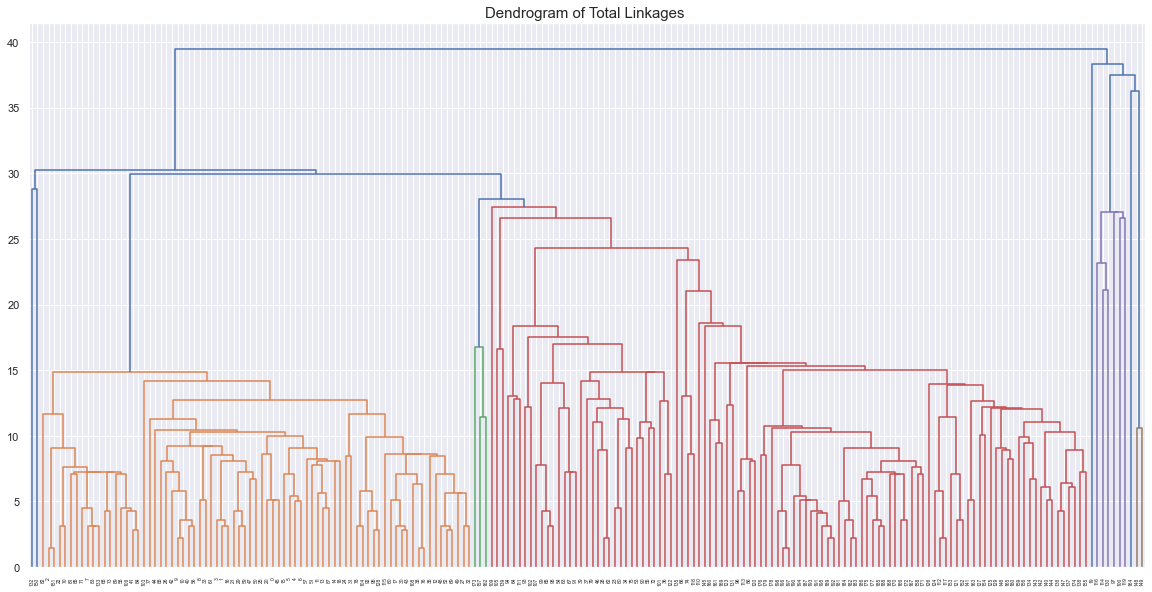

In [66]:
# check documentation ~> https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
# Plotting dendrogram
plt.figure(figsize=(20,10))
dendro = dendrogram(linkage_matrix)
plt.title('Dendrogram of Total Linkages ', fontsize = 15);

The total dendrogram is hard to read. Normally you cut the dendrogram tree with a horizontal line at a height where the line can traverse the maximum distance up and down without intersecting the merging point. This allows us some insight into how many clusters one should use. To make our task easier I will use the truncate mode "lastp" paramter to condense the dendrogram. Lastp returns the last _p_ non-singleton clustors formed in the linkage.

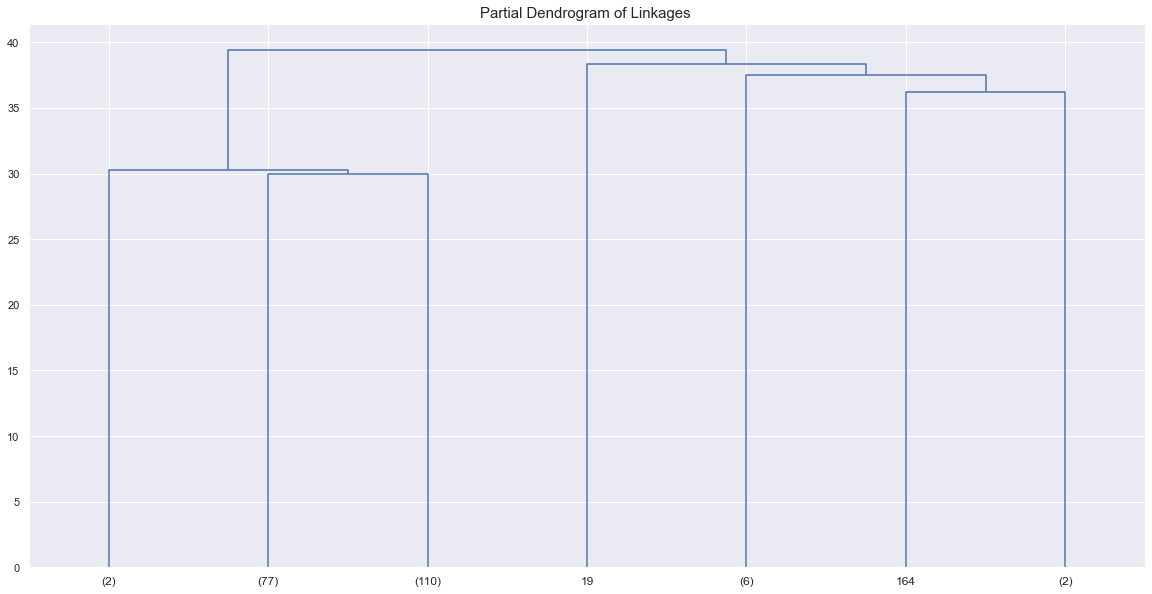

In [67]:
# using truncate mode to condense the dendrogram
plt.figure(figsize=(20,10))
dendro = dendrogram(linkage_matrix, truncate_mode = 'lastp', p=7)
plt.title('Partial Dendrogram of Linkages ', fontsize = 15);

In [68]:
mmscaled_df

Age    Income     Score  Gender_Female  Gender_Male
0    0.019231  0.000000  0.387755            0.0          1.0
1    0.057692  0.000000  0.816327            0.0          1.0
2    0.038462  0.008197  0.051020            1.0          0.0
3    0.096154  0.008197  0.775510            1.0          0.0
4    0.250000  0.016393  0.397959            1.0          0.0
..        ...       ...       ...            ...          ...
195  0.326923  0.860656  0.795918            1.0          0.0
196  0.519231  0.909836  0.275510            1.0          0.0
197  0.269231  0.909836  0.744898            0.0          1.0
198  0.269231  1.000000  0.173469            0.0          1.0
199  0.230769  1.000000  0.836735            0.0          1.0

[200 rows x 5 columns]

In [69]:
# This is our theorhetical max distance
np.sqrt(len(mmscaled_df.columns))

2.23606797749979

In [70]:
# Locate the position of oldest person
mmscaled_df['Age'].idxmax()

60

In [71]:
# Locate the position of youngest person
mmscaled_df['Age'].idxmin()

33

In [72]:
# setting the ages to variables so we can calc distance
age1 = mmscaled_df.iloc[60]
age2 = mmscaled_df.iloc[33]

In [73]:
# Find the euclidean distance between two points
distance = np.linalg.norm(age1-age2)
distance

1.07065318755951

In [74]:
age1

Age              1.000000
Income           0.254098
Score            0.561224
Gender_Female    0.000000
Gender_Male      1.000000
Name: 60, dtype: float64

In [75]:
age2

Age              0.000000
Income           0.147541
Score            0.928571
Gender_Female    0.000000
Gender_Male      1.000000
Name: 33, dtype: float64

In [76]:
# Lets focus on spending score as the metric to decide our distance threshold

# Locate the position of highest score
print('Index for highest score:', mmscaled_df['Score'].idxmax())
# Locate the position of lowest score
print('Index for lowest score:',mmscaled_df['Score'].idxmin())

score1 = mmscaled_df.iloc[11] #saving value for calculation
score2 = mmscaled_df.iloc[156] #saving value for calculation

# Find the euclidean distance between two points
score_distance = np.linalg.norm(score1-score2)
print("The Euclidean distance for Spending Score (highest-lowest) is:", score_distance)

Index for highest score: 11
Index for lowest score: 156
The Euclidean distance for Spending Score (highest-lowest) is: 1.7987091461042026


We can see that both the euclidean distance based on ages and also based on spending score indicate that we should use a
distance threshold of 2 in our model. When this distance threshold was used it resulted in 7 clusters being formed for our data and not the 6 we used based on Hierarchial clustering. Interestingly havingf a 7 clusters yielded a higher Silhouette score when we had completed Hierarchical clusetring but I still believe 6 clusters is ideal for this data set with such a small amount of features.

## Principal Component Anaylsis

Principal component analysis (PCA), is one of the most popular unsupervised machine learning techniques. It is primarily used as a dimensionality reduction approach with applications in data visualization and feature extraction, allowing for increased interpretability while minimizing information loss.

In dimensionality reduction, the goal of the inferred model is to represent the input data with the fewest number of dimensions, while still retaining information such as the variability in the data that is relevant to investigation. New component generated are combinations of proportions of existing features and these components explain the maximum variance in the model.

Our data set does not have many dimensions and hence PCA migh not be very useful since PCA is typically used when
we have many features. It however might be useful in creating a better clustering model.

In [77]:
# Recall we already used the standard scaler on our data and stored it as:
scaled_X

array([[-1.42456879, -1.73899919, -0.43480148, -1.12815215,  1.12815215],
       [-1.28103541, -1.73899919,  1.19570407, -1.12815215,  1.12815215],
       [-1.3528021 , -1.70082976, -1.71591298,  0.88640526, -0.88640526],
       [-1.13750203, -1.70082976,  1.04041783,  0.88640526, -0.88640526],
       [-0.56336851, -1.66266033, -0.39597992,  0.88640526, -0.88640526],
       [-1.20926872, -1.66266033,  1.00159627,  0.88640526, -0.88640526],
       [-0.27630176, -1.62449091, -1.71591298,  0.88640526, -0.88640526],
       [-1.13750203, -1.62449091,  1.70038436,  0.88640526, -0.88640526],
       [ 1.80493225, -1.58632148, -1.83237767, -1.12815215,  1.12815215],
       [-0.6351352 , -1.58632148,  0.84631002,  0.88640526, -0.88640526],
       [ 2.02023231, -1.58632148, -1.4053405 , -1.12815215,  1.12815215],
       [-0.27630176, -1.58632148,  1.89449216,  0.88640526, -0.88640526],
       [ 1.37433211, -1.54815205, -1.36651894,  0.88640526, -0.88640526],
       [-1.06573534, -1.54815205,  1.0

In [78]:
# help(PCA) check documentation

In [79]:
# Building Model
pca_model = PCA(n_components=2)

In [80]:
# Fitting the model -> ie calc the eigen values and eigenvectors
pca_model.fit(scaled_X)

PCA(n_components=2)

In [81]:
# transform the model -> projection... i.e the dot product
pca_model.transform(scaled_X)

array([[ 1.32190829e+00, -7.82593850e-01],
       [ 1.15001870e+00, -1.81681292e+00],
       [-1.32003278e+00,  6.07360185e-01],
       [-1.61384934e+00, -1.15995935e+00],
       [-1.37654369e+00,  2.34456765e-01],
       [-1.61503894e+00, -1.18630229e+00],
       [-1.18676491e+00,  1.34840967e+00],
       [-1.68466941e+00, -1.62589038e+00],
       [ 1.87798964e+00,  2.41946410e+00],
       [-1.52333871e+00, -6.86323906e-01],
       [ 1.85403933e+00,  2.27207653e+00],
       [-1.60223657e+00, -1.16596003e+00],
       [-1.02590985e+00,  2.24540259e+00],
       [-1.59405689e+00, -1.12399330e+00],
       [ 1.60610643e+00,  7.99600664e-01],
       [ 1.18162771e+00, -1.73032429e+00],
       [-1.30873721e+00,  5.55017103e-01],
       [ 1.22590297e+00, -1.48254749e+00],
       [ 1.67023099e+00,  1.10519314e+00],
       [-1.58645474e+00, -1.15286177e+00],
       [ 1.50142275e+00,  9.19916993e-02],
       [ 1.24542357e+00, -1.43263174e+00],
       [-1.06892774e+00,  1.89961566e+00],
       [ 1.

In [82]:
# doing it all in one step 
pca_results = pca_model.fit_transform(scaled_X)

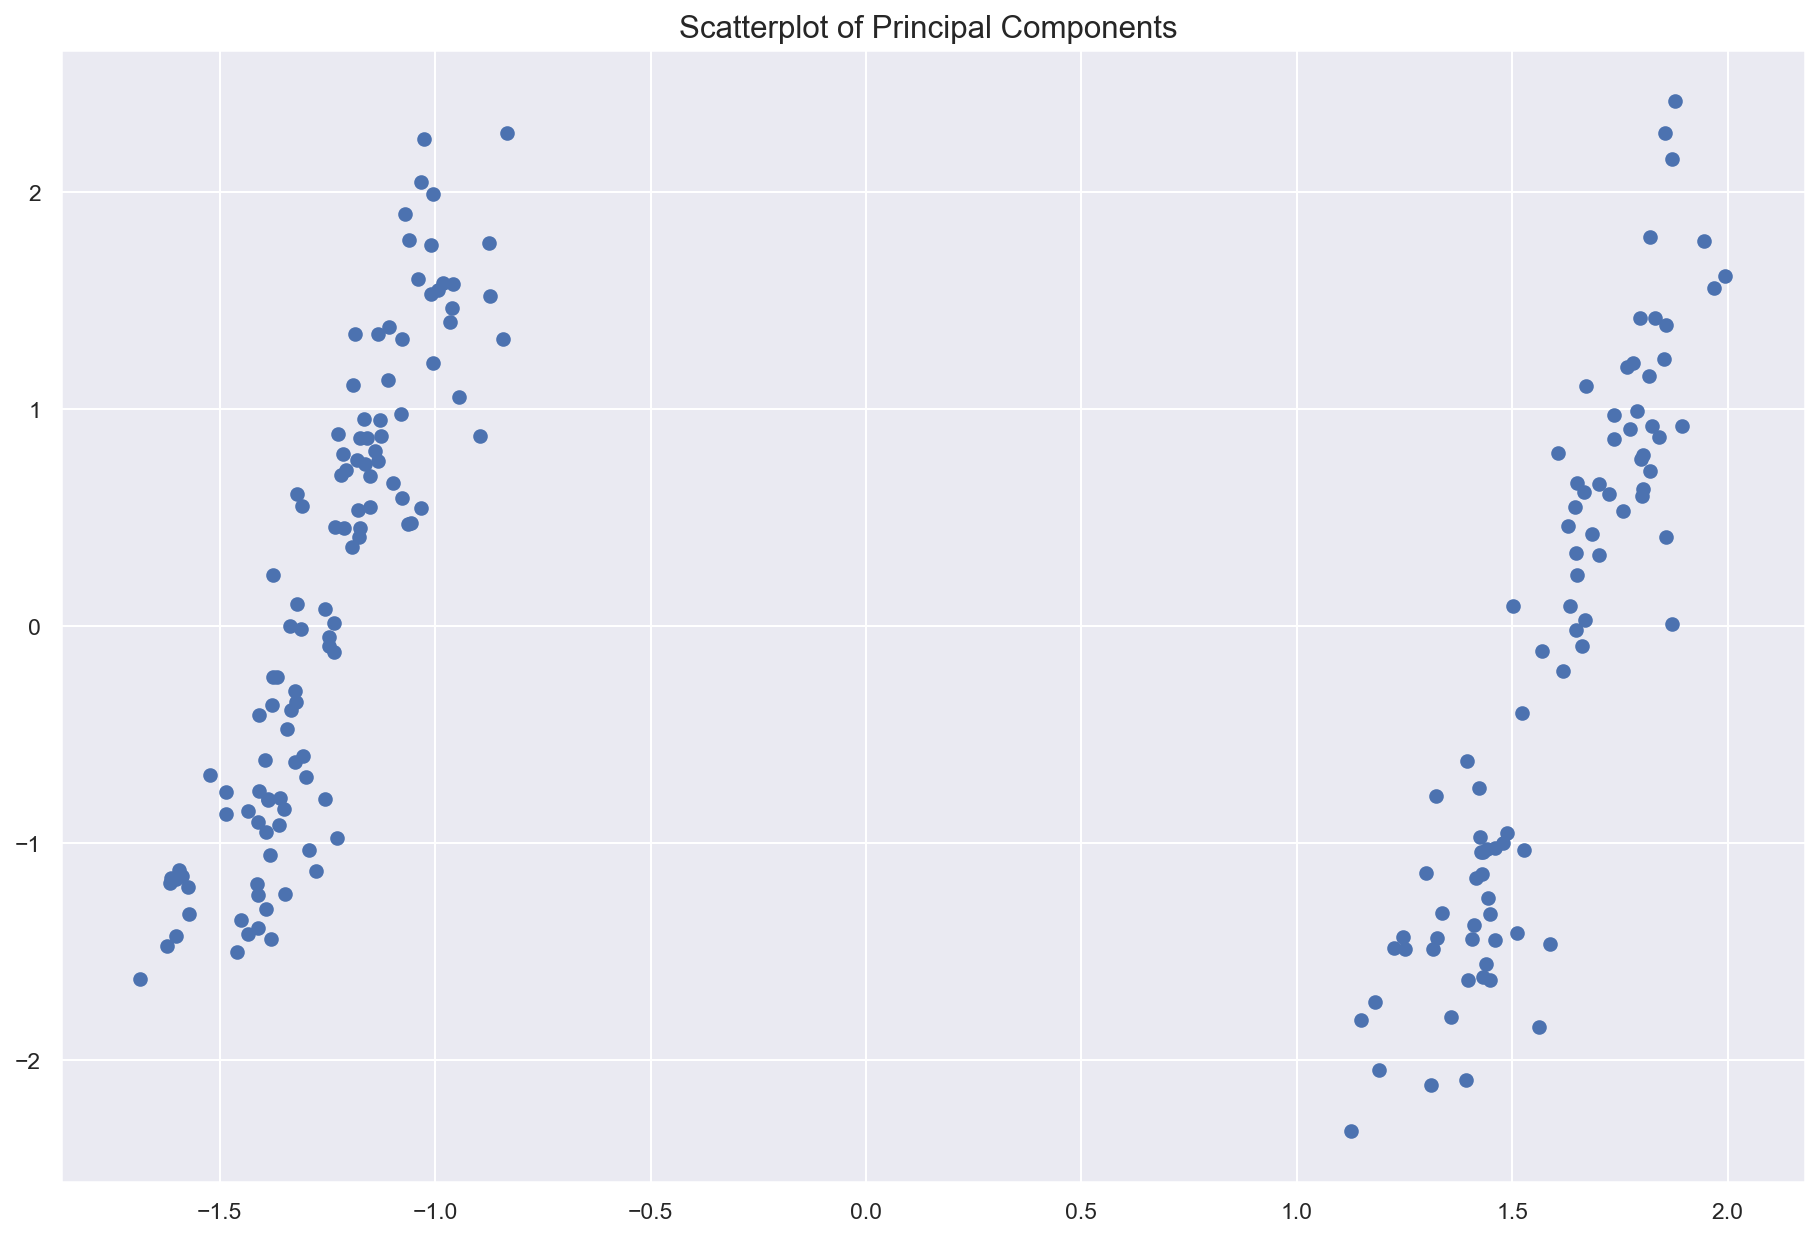

In [83]:
# plotting the components 
plt.figure(figsize=(15,10),dpi=150)
plt.scatter(pca_results[:,0],pca_results[:,1])
plt.title('Scatterplot of Principal Components ', fontsize = 15);

In [84]:
# components
pca_model.components_

array([[ 0.11855625,  0.07390773, -0.11585755, -0.69536289,  0.69536289],
       [ 0.69484399, -0.0910454 , -0.69546061,  0.11233235, -0.11233235]])

In [85]:
# needed to use a data frame with correct dimensions for below
X1 = X.drop(["KM3_clusters","KM6_clusters","Cluster"], axis=1)

In [86]:
# How much variance is explained by 2 principal components.
print('Total variance explained by 2 components:',round(100*np.sum(pca_model.explained_variance_ratio_),2),'%')

Total variance explained by 2 components: 66.71 %


In [87]:
# dataframe of the components from model ~> the direction of maximum variance in the data 
# shows the breakdown of variance
df_comp = pd.DataFrame(pca_model.components_,index = ['PC1', 'PC2'], columns = X1.columns)
df_comp

Age    Income     Score  Gender_Female  Gender_Male
PC1  0.118556  0.073908 -0.115858      -0.695363     0.695363
PC2  0.694844 -0.091045 -0.695461       0.112332    -0.112332

In [88]:
# selecting pca components to use in new Hierarchial clustering model
df_comp1 = pd.DataFrame(pca_results)
df_comp1.iloc[:,:]

0         1
0    1.321908 -0.782594
1    1.150019 -1.816813
2   -1.320033  0.607360
3   -1.613849 -1.159959
4   -1.376544  0.234457
..        ...       ...
195 -1.227359 -0.976973
196 -0.895962  0.877785
197  1.588228 -1.465029
198  1.871134  0.008680
199  1.561763 -1.845979

[200 rows x 2 columns]

Text(0.5, 1.0, 'Heatmap of Principal Components Breakdown ')

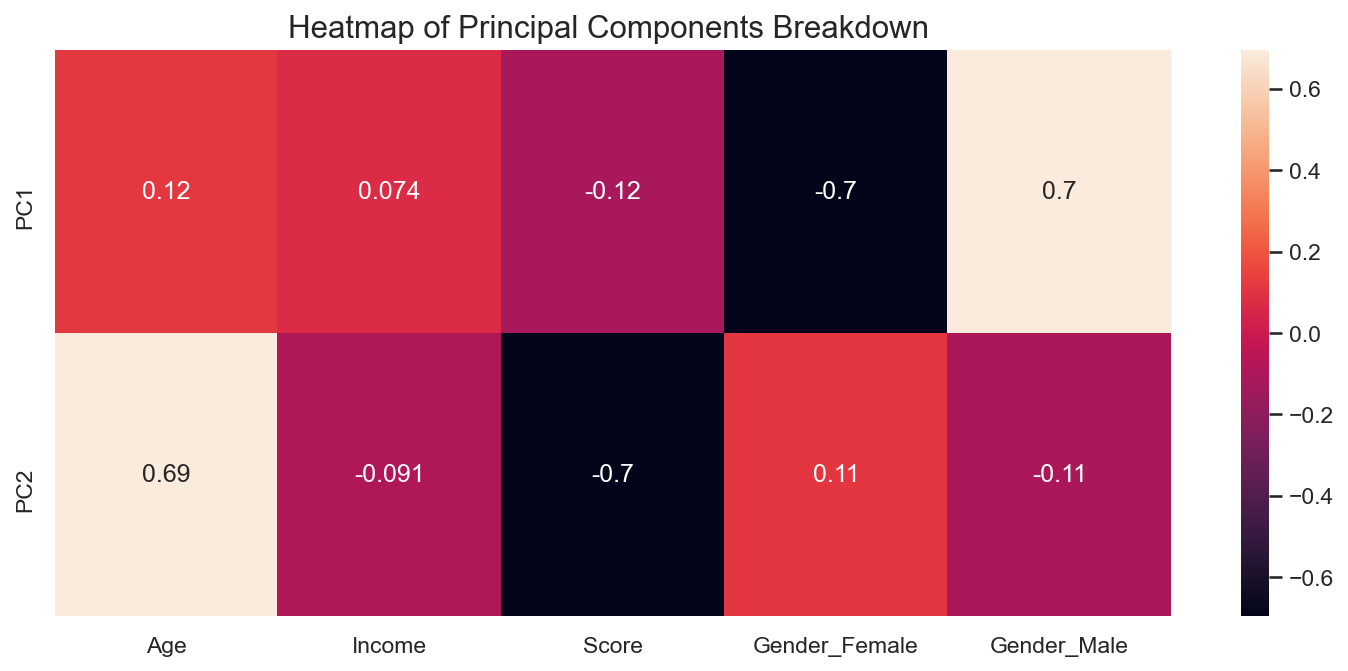

In [89]:
# Plotting a heatmap of our selected principal components
plt.figure(figsize=(12,5),dpi=150)
sns.heatmap(df_comp, annot=True)
plt.title('Heatmap of Principal Components Breakdown ', fontsize = 15)

In [90]:
# Building a model based on the first two PCA components to compare to Hierarchial CLustering completed before
#help(silhouette_score) ~> documentation
k_range = [ 2, 3, 4, 5, 6, 7]
for k in k_range:
    KM_PCAmodel = KMeans(n_clusters = k, max_iter = 25)
    KM_PCAfit = KM_PCAmodel.fit(df_comp1.iloc[:,:2])
    
    # Applying Silhouette Score
    silh_vals = silhouette_score(df_comp1.iloc[:,:2], KM_PCAfit.labels_, metric='euclidean')
    
    # print out the scores for each cluster
    print('When we have {0} clusters, the Silhouette Score is {1}'.format(k,silh_vals))

When we have 2 clusters, the Silhouette Score is 0.5917646144799474
When we have 3 clusters, the Silhouette Score is 0.6274248633835916
When we have 4 clusters, the Silhouette Score is 0.6734129487320962
When we have 5 clusters, the Silhouette Score is 0.6407127973845601
When we have 6 clusters, the Silhouette Score is 0.605448134388713
When we have 7 clusters, the Silhouette Score is 0.592022952716459


Based on the results seen above, it is clear that using the first two principal components yielded much better Silhouette scores and in fact also indicated that our ideal number of cluster should be four. We will briefly plot these clusters to take a look.

In [91]:
# PLotting a 3D model of  k=4 Clusters usa PCA imputs
import plotly.express as px

KM_model = KMeans(n_clusters=4)
KM_model.fit(df_comp1.iloc[:,:2])
labels = KM_model.predict(df_comp1.iloc[:,:2]) # predicted y vals
KM4_clusters = KM_model.labels_ # store the clusters

fig = px.scatter_3d(
    X,
    x='Age', y='Score',z='Income', 
    color=KM4_clusters.astype(str), opacity=0.75, height=650, width=650,
    color_discrete_sequence=px.colors.qualitative.Set2,
    title='3D Cluster Plot of 4 Cluster Model for Age, SpendingScore and Income')
fig.show()

From the plot above we can see that there is a good amount of separation between the clusters. 

# Conclusions

From our investigation into this data set using unsupervised maching learning methods we have found that: <br>  <br>
- **K-Means Clustering** initially suggested that we can segment our customers into 3 or 6 groups. <br> <br>
- **Hierarchical Clustering** suggested that we can segment our customers into 7 groups. <br>  <br>
- **Principal Component Analysis** returned 2 components that explained 67% percent of the variance in our data. Using          these two components we were able to build a better K-Means model that suggested our customers could be put into 4 groups.

Now that we have carefully analysed our models and have created well defined clusters, I decided to focus on the model that provided 6 clusters. I created coteries of our 6 clusters describing and suggesting how we might appeal to each group below.


#### Cluster 0: The Vibrant Spender   
This group consist mainly of young female adults who not only earn well but spend quite often or make large purchases. They have the second highest income and the highest overall spending score. This group could have either have a very young family with children or they go out and travel alot.
<br>They would appreciate discounts on many family based items as well as high priced clothings items, shoes and jewellery from top brands.

<br>

#### Cluster 1: The Risk Aversed Spender
This group consist mainly of middle aged female adults who not only have a low income but also a low spending score. This group most likely carefully considers each purchase and prioritizes needs over wants.They mostly likely try to save as much as possible and would not necessarily be seeking high priced items. 
<br>They would appreciate discounts on family based items and customer loyalty cards with frequent promotions and or weekly coupons.

<br>

#### Cluster 2: The Frugals  
This group is the only group dominanted by males. It consist mainly of middle aged adults who have the highest income yet share the smallest spending score with the previous group. This group most likely consist of single adults with no kids who are very careful with their finances and likely save and invest regularly.
<br> This group would appreciate coupons, promotions as well as loyalty cards.

<br>

#### Cluster 3:  The Experienced  
This group is the most balanced across all groups. It consist mainly of older aged females who have a medium income and medium  spending score. This group mostly likely either has college aged children or adult children and are primarily concerned with saving for their children's college expenses or retirement. 
<br> They would appreciate discounts either on items for college or toys and gifts for grandchildren as well as health items for older adults.

<br>

#### Cluster 4: The Up and Comers
THis group has the highest female concentration of all groups at 66%. It mainly consist of early 20's young adults who have a medium income and medium spending score just like the previous group. The group probably has the highest potential to become like the first group with high income and a high spending score. It mostly likely consist of single individuals without kids who are growing in their career and becoming more established and increasing income over time.
<br> This group would appreciate discounts on high priced status items, loyalty cards and also coupons on many female centric items since the group has the highest amount of females.

<br>

#### Cluster 5: The Spendrifts
This is an interesting group. It boasts the youngest adults (mainly females) of all groups with the second highest spending score yet one of the lowest incomes. This group most likely consist of inidividuals who are early in their career and probably are fresh out of college. They most likley enjoy going and eating out and likely live on the edge and spend above their means.<br>
What they wear, where they go and what they eat matter, so they mosly likely would appreciate discount on name brand clothing items and accessories, group discounts on travel and hotel services. 


# References

- https://towardsdatascience.com/customer-segmentation-with-python-31dca5d5bdad?source=user_profile
- https://www.kaggle.com/datark1/customers-clustering-k-means-dbscan-and-ap
